# Classification with Virtual Branching

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
from vbranch.callbacks import classification_acc
from vbranch.applications.fcn import SimpleFCNv1, SimpleFCNv2
from vbranch.applications.cnn import SimpleCNNSmall
from vbranch.losses import softmax_cross_entropy_with_logits
from vbranch.utils import *

Using TensorFlow backend.


In [3]:
SAVE = False
MODEL_ID = 1
ARCHITECTURE = 'fcn'
DATASET = 'mnist'
NUM_CLASSES = 10
NUM_FEATURES = None
SAMPLES_PER_CLASS = None
BAGGING_SAMPLES = 1.0
TRAIN_FRAC = 1.

NUM_BRANCHES = 3
SHARED_FRAC = 0.5
BATCH_SIZE = 64
EPOCHS = 50
STEPS_PER_EPOCH = 100

## Data

In [4]:
(X_train, y_train), (X_test, y_test) = get_data(DATASET, ARCHITECTURE, NUM_CLASSES,
                                                NUM_FEATURES, SAMPLES_PER_CLASS, 
                                                train_frac=TRAIN_FRAC)
print('Training set:', X_train.shape, y_train.shape)
print('Testing set:', X_test.shape, y_test.shape)

x_shape = (None,) + X_train.shape[1:]
y_shape = (None, NUM_CLASSES)

Training set: (60000, 784) (60000, 10)
Testing set: (10000, 784) (10000, 10)


We optionally perform bootstrap aggregation (bagging) by randomly sampling a random fraction of the original dataset. In general, bagging improves ensemble performance in addition to the gains from vanilla model averaging. A value of 0.6 works well for this task.

<br>
See original paper on bagging:

https://www.stat.berkeley.edu/~breiman/bagging.pdf

In [5]:
# Bagging
if BAGGING_SAMPLES > 0 and NUM_BRANCHES > 1:
    x_train_list, y_train_list = bag_samples(X_train, y_train, NUM_BRANCHES, 
                                             max_samples=0.5, bootstrap=True)

    for i, (x_, y_) in enumerate(zip(x_train_list, y_train_list)):
        print('Bag {}:'.format(i+1), x_.shape, y_.shape)

30000
Bag 1: (30000, 784) (30000, 10)
Bag 2: (30000, 784) (30000, 10)
Bag 3: (30000, 784) (30000, 10)


## Train

We use the TF Dataset API to train our models. Calling `get_data_iterator` returns the input tensor(s) and initializers for the training and testing data iterators. Each iterator will return random batches from the same data or different data (in the case of bagging). The initializers must be fed to the model compiler and will be called internalling during fitting.

In [6]:
# Note models from experiments will be saved in separate format
if not os.path.isdir('models'):
    os.system('mkdir models')

if NUM_BRANCHES == 1:
    model_name = '{}-{}_{:d}'.format(DATASET, ARCHITECTURE, MODEL_ID)
else:
    model_name = 'vb-{}-{}-B{:d}-S{:.2f}_{:d}'.format(DATASET, ARCHITECTURE,
                                                      NUM_BRANCHES, SHARED_FRAC, MODEL_ID)
model_path = os.path.join('models', model_name)
print('Model path:', model_path)

Model path: models/vb-mnist-fcn-B3-S0.50_1


In [7]:
tf.reset_default_graph()

inputs, labels, train_init_op, test_init_op = get_data_iterator(x_shape, y_shape, batch_size=BATCH_SIZE, 
                                                                n=NUM_BRANCHES, share_xy=BAGGING_SAMPLES ==0)

if NUM_BRANCHES > 1:
    for i, (ip_, label_) in enumerate(zip(inputs, labels)):
        print('Branch {}'.format(i+1))
        print('Input:', ip_)
        print('Label:', label_)
else:
    print('Single input (no branching)')
    print('Input:' , inputs)
    print('Label:', labels)

W0730 12:23:46.629568 140688977467136 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/utils/training.py:128: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 12:23:46.672741 140688977467136 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/utils/training.py:150: The name tf.data.Iterator is deprecated. Please use tf.compat.v1.data.Iterator instead.

W0730 12:23:46.678114 140688977467136 deprecation.py:323] From /home/gong/anaconda3/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py:348: Iterator.output_types (from tensorflow.python.data.ops.iterator_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
W0730 12:23:46.678830 140688977467136 deprecation.py:323] From /home/gong/anaconda3/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py:349: Iterator.output_shapes (from tensorflow.pyt

Branch 1
Input: Tensor("input:0", shape=(?, 784), dtype=float32)
Label: Tensor("input:1", shape=(?, 10), dtype=float32)
Branch 2
Input: Tensor("input_1:0", shape=(?, 784), dtype=float32)
Label: Tensor("input_1:1", shape=(?, 10), dtype=float32)
Branch 3
Input: Tensor("input_2:0", shape=(?, 784), dtype=float32)
Label: Tensor("input_2:1", shape=(?, 10), dtype=float32)


`Model` and `ModelVB` instances can be created using the function (defined in `vbranch.applications`). We declare the model under a `tf.variable_scope` in order to more easily retreive model parameters later on and enable parameter sharing between branches. Callbacks are used to calculate accuracy and other metrics during training.

In [8]:
name = 'model'

with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
    if ARCHITECTURE == 'fcn':
        model = SimpleFCNv1(inputs, NUM_CLASSES, name=name, shared_frac=SHARED_FRAC)
    elif ARCHITECTURE == 'fcn2':
        model = SimpleFCNv2(inputs, NUM_CLASSES, name=name, shared_frac=SHARED_FRAC)
    elif ARCHITECTURE == 'cnn':
        model = SimpleCNNSmall(inputs, NUM_CLASSES, name=name, shared_frac=SHARED_FRAC)
    else:
        raise ValueError('invalid model')

    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    model.compile(optimizer, softmax_cross_entropy_with_logits(), 
                  train_init_op, test_init_op, labels=labels, 
                  callbacks={'acc':classification_acc(NUM_BRANCHES)})

W0730 12:23:46.716928 140688977467136 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/vb_layers/core.py:63: The name tf.get_variable_scope is deprecated. Please use tf.compat.v1.get_variable_scope instead.

W0730 12:23:46.717833 140688977467136 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/vb_layers/core.py:92: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0730 12:23:46.718975 140688977467136 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/layers/core.py:76: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0730 12:23:46.730263 140688977467136 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/layers/core.py:83: The name tf.nn.xw_plus_b is deprecated. Please use tf.compat.v1.nn.xw_plus_b instead.

W0730 12:23:47.053814 140688977467136 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/engine/training.py:

In [9]:
model.summary()

i  Layer name                Output shape           Num param  Inbound  
------------------------------------------------------------------------
   Input                     [None,784]                                 
------------------------------------------------------------------------
   Input                     [None,784]                                 
------------------------------------------------------------------------
   Input                     [None,784]                                 
------------------------------------------------------------------------
0  fc1 (Dense)               [None,256] [None,256]  803840     input    
                             [None,256] [None,256]                      
                             [None,256] [None,256]                      
------------------------------------------------------------------------
1  bn1 (BatchNormalization)  [None,256] [None,256]  2048       fc1      
                             [None,256] [None,256] 

In [10]:
if NUM_BRANCHES > 1:
    print(model.losses)

{'loss_1': <tf.Tensor 'model/loss_1:0' shape=() dtype=float32>, 'loss_2': <tf.Tensor 'model/loss_2:0' shape=() dtype=float32>, 'loss_3': <tf.Tensor 'model/loss_3:0' shape=() dtype=float32>}


In [11]:
model.output

[<tf.Tensor 'model/output/vb1/output:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'model/output/vb2/output:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'model/output/vb3/output:0' shape=(?, 10) dtype=float32>]

In order to train the model, we must supply the training and validation data. The training data can either be shared or different (in the case of bagging). Either way, the batches are random so each branch gets "different" data. Finally, we call the `fit` method, which handles both `Model` and `ModelVB` and returns a dictionary of all metrics over epochs. 

In [12]:
if NUM_BRANCHES == 1 or BAGGING_SAMPLES == 0:
    train_dict = {'x:0': X_train, 'y:0': y_train, 'batch_size:0': BATCH_SIZE}
else:
    train_dict = {'x:0': X_train, 'y:0': y_train}
    for i in range(NUM_BRANCHES):
        train_dict['vb{}_x:0'.format(i+1)] = x_train_list[i]
        train_dict['vb{}_y:0'.format(i+1)] = y_train_list[i]
    train_dict['batch_size:0'] = BATCH_SIZE
    
val_dict = {'x:0': X_test, 'y:0': y_test, 'batch_size:0': len(X_test)}

In [13]:
history = model.fit(EPOCHS, STEPS_PER_EPOCH, train_dict=train_dict,
                    val_dict=val_dict, log_path=model_path if SAVE else None)

Epoch 1/50
100/100 - 3s - loss_1: 0.4480 - loss_2: 0.4329 - loss_3: 0.4314 - acc_ensemble: 0.9468 - acc_1: 0.9391 - acc_2: 0.9394 - acc_3: 0.9374 - val_loss_1: 0.2058 - val_loss_2: 0.2138 - val_loss_3: 0.2158 - val_acc_ensemble: 0.9445 - val_acc_1: 0.9365 - val_acc_2: 0.9357 - val_acc_3: 0.9354
Epoch 2/50
100/100 - 2s - loss_1: 0.1702 - loss_2: 0.1804 - loss_3: 0.1779 - acc_ensemble: 0.9586 - acc_1: 0.9538 - acc_2: 0.9520 - acc_3: 0.9528 - val_loss_1: 0.1631 - val_loss_2: 0.1739 - val_loss_3: 0.1712 - val_acc_ensemble: 0.9558 - val_acc_1: 0.9505 - val_acc_2: 0.9482 - val_acc_3: 0.9496
Epoch 3/50
100/100 - 2s - loss_1: 0.1356 - loss_2: 0.1300 - loss_3: 0.1340 - acc_ensemble: 0.9658 - acc_1: 0.9569 - acc_2: 0.9610 - acc_3: 0.9574 - val_loss_1: 0.1591 - val_loss_2: 0.1558 - val_loss_3: 0.1608 - val_acc_ensemble: 0.9602 - val_acc_1: 0.9509 - val_acc_2: 0.9551 - val_acc_3: 0.9525
Epoch 4/50
100/100 - 2s - loss_1: 0.1091 - loss_2: 0.0985 - loss_3: 0.0982 - acc_ensemble: 0.9717 - acc_1: 0.966

Epoch 29/50
100/100 - 2s - loss_1: 0.0043 - loss_2: 0.0031 - loss_3: 0.0049 - acc_ensemble: 0.9871 - acc_1: 0.9823 - acc_2: 0.9844 - acc_3: 0.9833 - val_loss_1: 0.1053 - val_loss_2: 0.0978 - val_loss_3: 0.1004 - val_acc_ensemble: 0.9752 - val_acc_1: 0.9707 - val_acc_2: 0.9756 - val_acc_3: 0.9722
Epoch 30/50
100/100 - 2s - loss_1: 0.0042 - loss_2: 0.0041 - loss_3: 0.0039 - acc_ensemble: 0.9880 - acc_1: 0.9854 - acc_2: 0.9843 - acc_3: 0.9834 - val_loss_1: 0.0981 - val_loss_2: 0.0996 - val_loss_3: 0.1019 - val_acc_ensemble: 0.9759 - val_acc_1: 0.9736 - val_acc_2: 0.9750 - val_acc_3: 0.9725
Epoch 31/50
100/100 - 2s - loss_1: 0.0029 - loss_2: 0.0053 - loss_3: 0.0048 - acc_ensemble: 0.9877 - acc_1: 0.9845 - acc_2: 0.9831 - acc_3: 0.9838 - val_loss_1: 0.1031 - val_loss_2: 0.1074 - val_loss_3: 0.0974 - val_acc_ensemble: 0.9758 - val_acc_1: 0.9722 - val_acc_2: 0.9723 - val_acc_3: 0.9747
Epoch 32/50
100/100 - 2s - loss_1: 0.0043 - loss_2: 0.0062 - loss_3: 0.0042 - acc_ensemble: 0.9877 - acc_1: 0

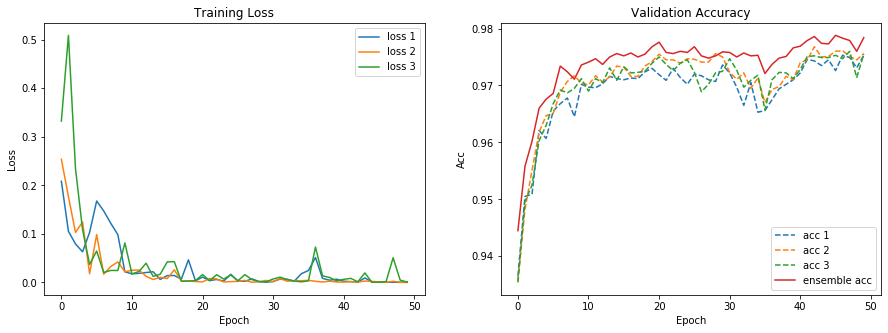

In [14]:
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
for i in range(NUM_BRANCHES):
    plt.plot(history['loss_{}'.format(i+1)], label='loss {}'.format(i+1))
#     plt.plot(history['loss'], label='loss {}'.format(i+1))
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
for i in range(NUM_BRANCHES):
    plt.plot(history['val_acc_{}'.format(i+1)], linestyle='--', label='acc {}'.format(i+1))
#     plt.plot(history['val_acc'], linestyle='--', label='acc {}'.format(i+1))
plt.plot(history['val_acc_ensemble'], label='ensemble acc')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()

plt.show()

The ensemble never has validation accuracy greater than the individual branches. In fact, the ensemble accuracy exceeds the individual accuracies by a large margin for most epochs. Of course, this is only a limited example. See below for more comprehensive results.

Run the following script in the terminal to perform multiple trials of the code above and with varying hyperparameters. Individual configurations can also be called from the terminal using the following scripts (arguments shown).

In [37]:
# for batch_size in [40, 80, 100, 160, 200]:
#     path = 'batch_size/mnist-fcn/batch_' + str(batch_size)
#     cmd = 'python experiments/classification/baseline.py --dataset mnist --architecture fcn ' + \
#             '--epochs 15 --trials 8 --batch_size {} --path {}'.format(batch_size, path)
#     print(cmd)
#     os.system(cmd)

python experiments/classification/baseline.py --dataset mnist --architecture fcn --epochs 15 --trials 8 --batch_size 40 --path batch_size/mnist-fcn/batch_40
python experiments/classification/baseline.py --dataset mnist --architecture fcn --epochs 15 --trials 8 --batch_size 80 --path batch_size/mnist-fcn/batch_80
python experiments/classification/baseline.py --dataset mnist --architecture fcn --epochs 15 --trials 8 --batch_size 100 --path batch_size/mnist-fcn/batch_100
python experiments/classification/baseline.py --dataset mnist --architecture fcn --epochs 15 --trials 8 --batch_size 160 --path batch_size/mnist-fcn/batch_160
python experiments/classification/baseline.py --dataset mnist --architecture fcn --epochs 15 --trials 8 --batch_size 200 --path batch_size/mnist-fcn/batch_200


In [ ]:
for train_frac in [40, 80, 100, 160, 200]:
    path = 'batch_size/mnist-fcn/batch_' + str(batch_size)
    cmd = 'python experiments/classification/baseline.py --dataset mnist --architecture fcn ' + \
            '--epochs 15 --trials 8 --batch_size {} --path {}'.format(batch_size, path)
    print(cmd)
    os.system(cmd)

## Evaluation

In [5]:
import time
from sklearn.manifold import TSNE

In [6]:
from vbranch.utils.generic import get_model_path, get_vb_model_path
from vbranch.utils.test import baseline_classification, compute_correlation_strength, compute_acc_from_logits

### Feature Visualization

In [7]:
def get_tsne(features):
    start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(features)

    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-start))
    return tsne_results

In [8]:
X_sample, y_sample = bag_samples(X_train, y_train, 1, max_samples=250)
print('Sample:', X_sample.shape, y_sample.shape)

Sample: (250, 784) (250, 10)


In [9]:
tf.reset_default_graph()
model_path = get_model_path(DATASET, ARCHITECTURE, model_id=1)

with TFSessionGrow() as sess:
    restore_sess(sess, model_path)
    sess.run('test_init_op', feed_dict={'x:0':X_sample, 'y:0': y_sample, 
                                        'batch_size:0':len(X_sample)})
    baseline_features = sess.run('model/output/output:0')

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/mnist-fcn2/model_1/ckpt


In [10]:
tf.reset_default_graph()
model_path = get_vb_model_path(DATASET, ARCHITECTURE, NUM_BRANCHES, 
                               SHARED_FRAC, model_id=MODEL_ID)
    
with TFSessionGrow() as sess:
    restore_sess(sess, model_path)
    test_init_ops = []
    outputs = []
    for i in range(NUM_BRANCHES):
        test_init_ops.append('test_init_op_{}'.format(i+1))
        name = 'model/output/vb{}/output:0'.format(i+1)
        outputs.append(name)
    
    sess.run(test_init_ops, feed_dict={'x:0':X_sample, 'y:0': y_sample, 
                                       'batch_size:0':len(X_sample)})
    vbranch_features = sess.run(outputs)
    mean_vbranch_features = np.mean(vbranch_features, axis=0)

INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn2/B2/S0.25/model_1/ckpt


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 250 samples in 0.000s...
[t-SNE] Computed neighbors for 250 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 250 / 250
[t-SNE] Mean sigma: 7.030403
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.796883
[t-SNE] KL divergence after 300 iterations: 0.344064
t-SNE done! Time elapsed: 0.3213036060333252 seconds
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 250 samples in 0.000s...
[t-SNE] Computed neighbors for 250 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 250 / 250
[t-SNE] Mean sigma: 8.318750
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.989750
[t-SNE] KL divergence after 300 iterations: 0.345082
t-SNE done! Time elapsed: 0.31092071533203125 seconds


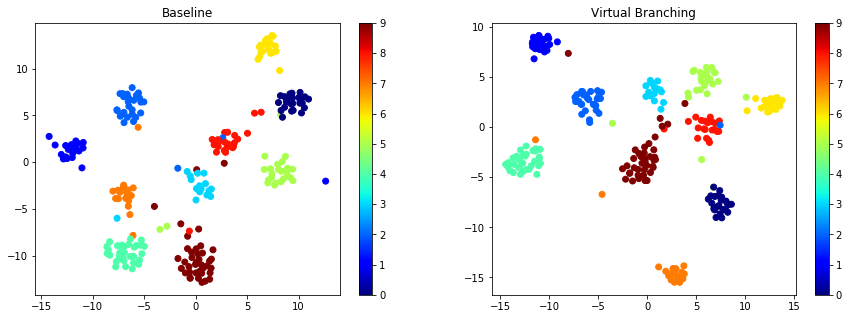

In [11]:
baseline_tsne = get_tsne(baseline_features)
vbranch_tsne = get_tsne(mean_vbranch_features)
sample_labels = np.argmax(y_sample, axis=-1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.scatter(baseline_tsne[:,0], baseline_tsne[:,1], c=sample_labels, cmap=plt.cm.jet)
plt.colorbar()
plt.title('Baseline')

plt.subplot(1, 2, 2)
plt.scatter(vbranch_tsne[:,0], vbranch_tsne[:,1], c=sample_labels, cmap=plt.cm.jet)
plt.colorbar()
plt.title('Virtual Branching')

plt.show()

### Correlation and Strength

For classification, we can compute the correlation between models and their strength. The formulas used are from the Random Forest paper:

https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf

In [12]:
# Baseline

y_labels = np.argmax(y_test, axis=-1)

model_id_list = range(1, 9)
output_list = []
acc_list = []
pred_list = []

for model_id in model_id_list:
    tf.reset_default_graph()

    with tf.Session() as sess:
        model_path = get_model_path(DATASET, ARCHITECTURE, NUM_CLASSES, 
                                    SAMPLES_PER_CLASS, model_id=model_id)
        restore_sess(sess, model_path)
        sess.run('test_init_op', feed_dict={'x:0':X_test, 'y:0': y_test, 
                                        'batch_size:0':len(X_test)})
        output = sess.run('model/output/output:0'.format(model_id))

    output_list.append(output)
    acc_list.append(compute_acc_from_logits(output, y_test, NUM_CLASSES))
    pred_list.append(np.argmax(output, axis=1))
    
model_preds = np.array(pred_list).transpose(1,0)
baseline_corr, baseline_strength = compute_correlation_strength(model_preds, y_labels, 
                                                                NUM_CLASSES, 
                                                                len(model_id_list))

print('Mean correlation:', baseline_corr)
print('Strength:' , baseline_strength)

INFO:tensorflow:Restoring parameters from models/mnist-fcn2/model_1/ckpt
INFO:tensorflow:Restoring parameters from models/mnist-fcn2/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/mnist-fcn2/model_3/ckpt
INFO:tensorflow:Restoring parameters from models/mnist-fcn2/model_4/ckpt
INFO:tensorflow:Restoring parameters from models/mnist-fcn2/model_5/ckpt
INFO:tensorflow:Restoring parameters from models/mnist-fcn2/model_6/ckpt
INFO:tensorflow:Restoring parameters from models/mnist-fcn2/model_7/ckpt
INFO:tensorflow:Restoring parameters from models/mnist-fcn2/model_8/ckpt
Mean correlation: 0.5901408352877151
Strength: 0.8988125


In [13]:
# Virtual branching

shared_frac_list = [0, 0.25, 0.5, 0.75, 1.]
shared_correlation_list = []
shared_strength_list = []

for shared in shared_frac_list:
    mean_correlation_list = []
    strength_list = []
    
    for model_id in range(1, 5):
        model_path = get_vb_model_path(DATASET, ARCHITECTURE, NUM_BRANCHES, shared, 
                                       NUM_CLASSES, SAMPLES_PER_CLASS, model_id=model_id)

        test_init_ops = []
        tensors = []
        for i in range(NUM_BRANCHES):
            test_init_ops.append('test_init_op_{}'.format(i+1))
            tensors.append('model/output/vb{}/output:0'.format(i+1))

        tf.reset_default_graph()

        with tf.Session() as sess:
            restore_sess(sess, model_path)
            sess.run(test_init_ops, feed_dict={'x:0':X_test, 'y:0': y_test, 
                                        'batch_size:0':len(X_test)})
            outputs = sess.run(tensors)
            
        preds = np.array([np.argmax(x, axis=1) for x in outputs]).transpose(1,0)
        mean_correlation, strength = compute_correlation_strength(preds, y_labels, 
                                                                  NUM_CLASSES, NUM_BRANCHES)
        mean_correlation_list.append(mean_correlation)
        strength_list.append(strength)
        
    shared_correlation_list.append([np.mean(mean_correlation_list), np.std(mean_correlation_list)])
    shared_strength_list.append([np.mean(strength_list), np.std(strength_list)])

INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn2/B2/S0.00/model_1/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn2/B2/S0.00/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn2/B2/S0.00/model_3/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn2/B2/S0.00/model_4/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn2/B2/S0.25/model_1/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn2/B2/S0.25/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn2/B2/S0.25/model_3/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn2/B2/S0.25/model_4/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn2/B2/S0.50/model_1/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn2/B2/S0.50/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn2/B2/S0.50/model_3/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn2/B2

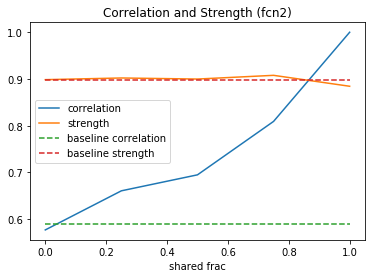

In [19]:
plt.plot(shared_frac_list, np.array(shared_correlation_list)[:, 0], label='correlation')
plt.plot(shared_frac_list, np.array(shared_strength_list)[:, 0], label='strength')

# Baseline
plt.plot(shared_frac_list, [baseline_corr]* len(shared_correlation_list), 
         label='baseline correlation', linestyle='--')
plt.plot(shared_frac_list, [baseline_strength]* len(shared_correlation_list), 
         label='baseline strength', linestyle='--')

plt.xlabel('shared frac')
plt.title('Correlation and Strength ({})'.format(ARCHITECTURE))
plt.legend()

plt.savefig('figs/correlation-strength.png')
plt.show()

### Model Parameters

In [4]:
tf.reset_default_graph()
inputs = tf.placeholder('float32', [None, 28,28,1])

# Baseline
model = SimpleCNNSmall(inputs, NUM_CLASSES)
baseline_params = model.count_parameters()
print('Baseline parameters:', baseline_params)

Instructions for updating:
Colocations handled automatically by placer.
Baseline parameters: 18010


In [5]:
# Vbranch params
shared_frac_list = [0, 0.25, 0.5, 0.75, 1.]

vbranch_params = []
for frac in shared_frac_list:
    tf.reset_default_graph()
    with tf.variable_scope('model', reuse=tf.AUTO_REUSE):
        inputs = tf.placeholder('float32', [None, 28,28,1])
        model = SimpleCNNSmall([inputs]*NUM_BRANCHES, NUM_CLASSES, shared_frac=frac)
    vbranch_params.append(model.count_parameters())

In [6]:
param_ratio = [p / baseline_params for p in vbranch_params]
ideal_ratio = NUM_BRANCHES - np.array(shared_frac_list)**2 * (NUM_BRANCHES-1)

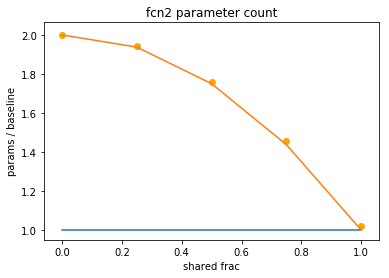

In [7]:
plt.scatter(shared_frac_list, param_ratio, color='orange')
plt.plot(shared_frac_list, [1]*len(shared_frac_list))
plt.plot(shared_frac_list, ideal_ratio)

plt.xlabel('shared frac')
plt.ylabel('params / baseline')
plt.title('{} parameter count'.format(ARCHITECTURE))

plt.savefig('figs/cnn-small-parameter-count.png')
plt.show()